 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

# Introduction

The LMU site is located near Munich blah blah blah

# Data preparation

First, it is important to define the `**state mask**`, which basically is a raster that encodes the locations where the land surface parameters will be inferred. In this case, we have a Shapefile with the fields where data of interest have been collected over the LMU field campaign, and we will limit the inference to these fields only. The file in in [`data/ESU.shp`](data/ESU.shp), so we can just rasterise it into a 10m grid with the following extent

Extent in current projection: (697361.573352, 5347596.516110) - (703248.269722, 5354394.970670)
Rounded off for 10m grid 697100 5347200 703600 5354600

We can achieve that with the `gdal_rasterize` command:

    gdal_rasterize -of GTiff -burn 1 -te 697100 5347200 703600 5354600 -tr 10 10 -ot Byte \
                   -co "COMPRESS=DEFLATE" -l MNI_2017 MNI_2017.shp ESU.tif



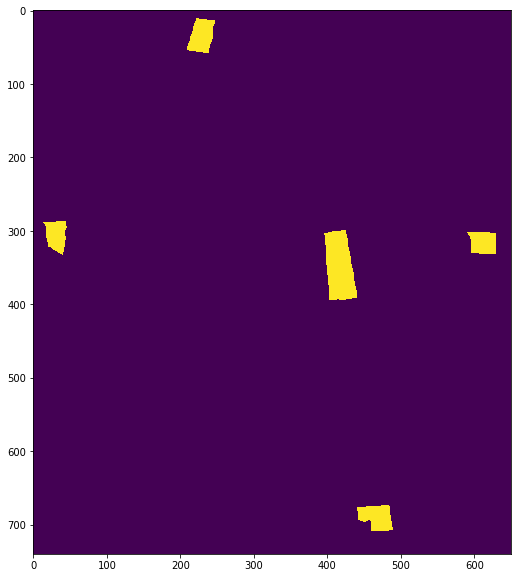

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gdal
import kafka

g = gdal.Open("data/ESU.tif")
state_mask = g.ReadAsArray().astype(np.bool)
plt.figure(figsize=(10, 10))
plt.imshow(state_mask, interpolation="nearest")

In [3]:
import osr
def reproject_image(source_img, target_img, dstSRSs=None):
    """Reprojects/Warps an image to fit exactly another image.
    Additionally, you can set the destination SRS if you want
    to or if it isn't defined in the source image."""
    g = gdal.Open(target_img)
    geo_t = g.GetGeoTransform()
    x_size, y_size = g.RasterXSize, g.RasterYSize
    xmin = min(geo_t[0], geo_t[0] + x_size * geo_t[1])
    xmax = max(geo_t[0], geo_t[0] + x_size * geo_t[1])
    ymin = min(geo_t[3], geo_t[3] + y_size * geo_t[5])
    ymax = max(geo_t[3], geo_t[3] + y_size * geo_t[5])
    xRes, yRes = abs(geo_t[1]), abs(geo_t[5])
    if dstSRSs is None:
        dstSRS = osr.SpatialReference()
        raster_wkt = g.GetProjection()
        dstSRS.ImportFromWkt(raster_wkt)
    else:
        dstSRS = dstSRSs
    g = gdal.Warp('', source_img, format='MEM',
                  outputBounds=[xmin, ymin, xmax, ymax], xRes=xRes, yRes=yRes,
                  dstSRS=dstSRS)
    return g

NETCDF:"data/S1B_IW_SLC__1SDV_20170317T052529_20170317T052556_004744_008495_CE08_GC_RC_No_Su_Co_speckle.nc":sigma0_VH


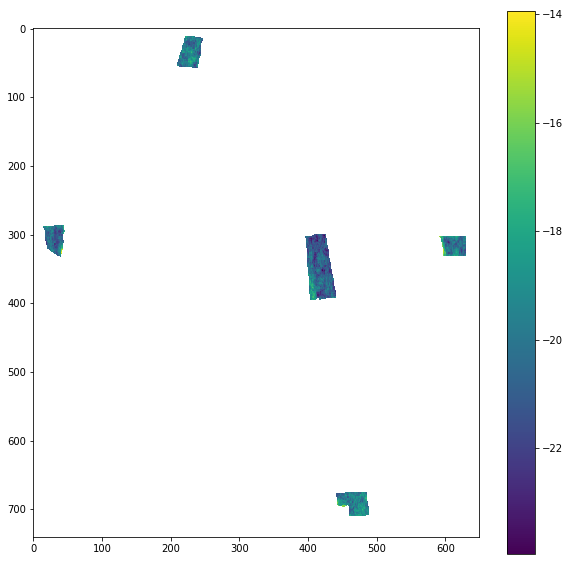

In [9]:
fname = "data/S1B_IW_SLC__1SDV_20170317T052529_20170317T052556_004744_008495_CE08_GC_RC_No_Su_Co_speckle.nc"
obs_file = 'NETCDF:"{:s}":sigma0_VH'.format(fname)
print obs_file
sigma_vh = reproject_image(obs_file, "data/ESU.tif").ReadAsArray()
obs_mask = sigma_vh < -900
sigma_vh[obs_mask] = np.nan
sigma_vh[~state_mask] = np.nan
plt.figure(figsize=(10,10))
plt.imshow(10*np.log10(sigma_vh), interpolation="nearest")
plt.colorbar()

/opt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(1122, 1683)


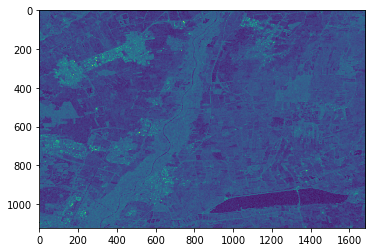

In [8]:
g = gdal.Open(obs_file)
data = g.ReadAsArray()
plt.imshow(10*np.log10(data))
print data.shape

In [4]:
sentinel1_observations = kafka.Sentinel1_Observations.S1Observations(
    "/media/ucfajlg/WERKLY/jose/new/", "data/ESU.tif", emulators={
        'VH': kafka.observation_operators.sar_observation_operator, 
        'VV': kafka.observation_operators.sar_observation_operator})

2017-03-14 16:58:52
2017-03-18 05:18:04
2017-03-19 17:07:04


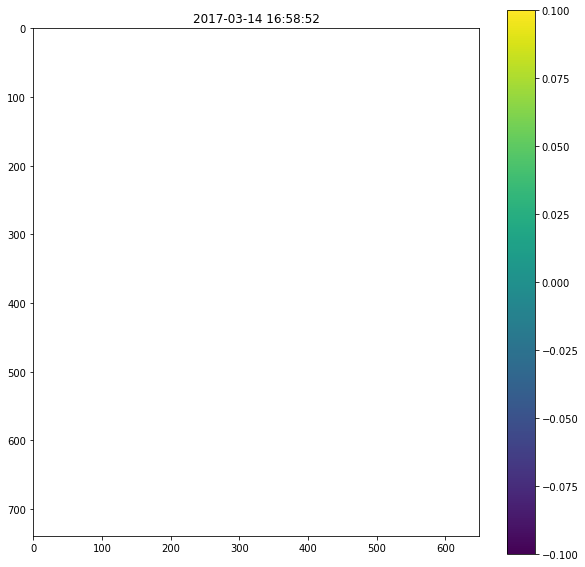

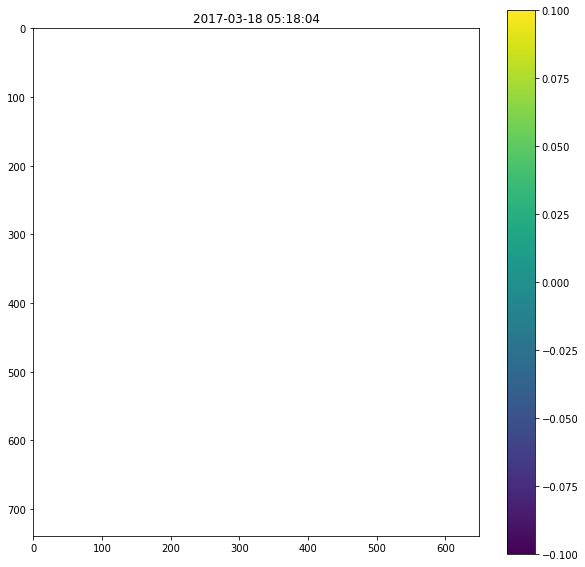

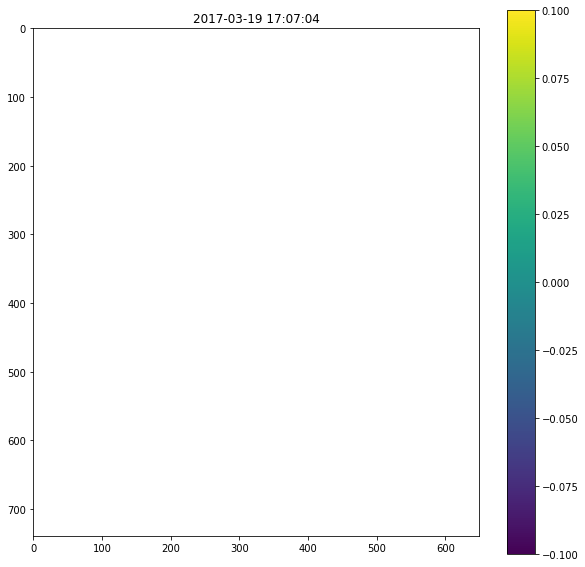

In [5]:
for tim in sentinel1_observations.dates:
    print tim
    data = sentinel1_observations.get_band_data(tim, 0)
    plt.figure(figsize=(10,10))
    observations = data.observations*1.
    observations[data.mask] = np.nan
    observations[~state_mask] = np.nan
    sigma_vv = observations
    data = sentinel1_observations.get_band_data(tim, 1)
    plt.figure(figsize=(10,10))
    observations = data.observations*1.
    observations[data.mask] = np.nan
    observations[~state_mask] = np.nan
    sigma_vh = observations
    
    plt.imshow(10.*np.log(sigma_vh/sigma_vv), interpolation="nearest")
    plt.colorbar()
    plt.title(tim)

In [6]:
kalman_filter = kafka.LinearKalman(sentinel1_observations, None, state_mask, 
                                   kafka.observation_operators.create_sar_observation_operator,
                                   linear=False, n_params=2, diagnostics=True, bands_per_observation=2)

In [10]:
kafka.LinearKalman?

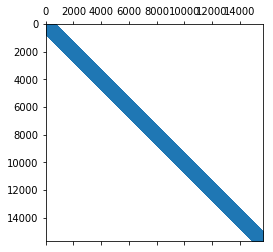

In [7]:
import scipy.sparse as sp
mean_lai0 = np.zeros((740, 650))
mean_sm0 = np.zeros((740, 650))
std_lai0 = np.zeros((740, 650))
std_sm0 = np.zeros((740, 650))

mean_lai0[state_mask] = 2
mean_sm0[state_mask] = 0.1
std_lai0[state_mask] = 2.
std_sm0[state_mask] = 0.2


x_prior = np.c_[mean_lai0[state_mask], mean_sm0[state_mask]].flatten()
sigma_prior = np.c_[std_lai0[state_mask], std_sm0[state_mask]].flatten()
sigma_prior_inv = 1./(sigma_prior**2)
N = sigma_prior_inv.shape[0]
P_inv = sp.lil_matrix((N, N))
P_inv.setdiag(sigma_prior_inv)
plt.spy(P_inv)

In [8]:
import datetime
time_grid = [datetime.datetime(2017, 3, 14),
             datetime.datetime(2017, 3, 15),
             datetime.datetime(2017, 3, 16),
             datetime.datetime(2017, 3, 17)
            ]

In [9]:
kalman_filter.run(time_grid, x_prior, None, P_inv)

ValueError: need more than 0 values to unpack

In [ ]:
%debug

In [ ]:
taita